# Prédiction de l'origine de chansons

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from autograd import grad
import autograd.numpy as np
from autograd.misc.optimizers import sgd
from autograd.misc import flatten
import autograd.numpy.random as rdm

from sklearn.model_selection import train_test_split

# Import des données 

In [2]:
data_folder = 'Geographical Original of Music/'
data_path = data_folder + '/default_plus_chromatic_features_1059_tracks.txt'
data = pd.read_csv(data_path , header=None)
heatmaps = np.loadtxt('Geographical Original of Music/heatmap.txt')

In [3]:
i = 114
while sum(data.iloc[:, 115] == data.iloc[:, i]) == data.shape[0]:
    i -= 1
print(i)

103


On remarque que les 12 dernières features sont identiques pour chaque chanson. Ces données étant redondantes on devrait les supprimer ce qui permettrait de gagner en efficacité mais on les conserve par respect des consignes de l'exercice.

In [4]:
val_size = 0.2
inputs = np.array(data.iloc[:,0:116])
targets = np.array(data.iloc[:,116:118])
train_inputs, val_inputs,train_targets, val_targets = train_test_split(
    inputs, targets, test_size=val_size, random_state=3)

In [5]:
print(train_inputs.shape)
print(train_targets.shape)
print(data.iloc[:,116:118].describe())

(847, 116)
(847, 2)
               116          117
count  1059.000000  1059.000000
mean     26.651294    38.405656
std      18.459432    50.419790
min     -35.300000   -88.760000
25%      14.660000     3.210000
50%      33.660000    32.830000
75%      39.910000    74.600000
max      54.680000   149.120000


# Réseaux de Neurones

On construit ici les différentes fonctions qui permettront d'implémenter les réseaux de neurones et leur entrainement par descente de gradient.

#### Initialisation des paramètres

On initialise aléatoirement les poids du réseaux de neurones. Il est important d'avoir recours à l'aléatoire pour cette étape pour éviter toute symétrie entre les cellules du réseau. En effet si on initialise tous les poids de façon identiques alors toutes les cellules recevront le même signal (quelques soient les inputs) et évolueront de la même façon. <br>

In [6]:
def init_params(layers_sizes, rstate=rdm.RandomState(0)):
        return [rstate.randn(in_s, out_s)
                for in_s, out_s in zip(layers_sizes[:-1], layers_sizes[1:])]

#### Application du réseau de neurones aux données ("feed-forward")

In [7]:
def forward(inputs, params, activation=np.tanh):
    for w in params:
        outputs = np.dot(inputs, w)
        inputs = np.tanh(outputs)
    return activation(outputs)

In [8]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=0) 

#### Descente de gradient 

La descente de gradient permet de mettre à jour les poids du réseaux pour minimiser la perte en utilisant la formule : 
$$
W = W - \gamma * \nabla \mathcal{L}
$$
où $\nabla \mathcal{L}$ est le gradient de la perte par rapport au pramètre $W$ et $\gamma$ est le "learning rate" que l'on choisi arbitrairement. <br>
A chaque itération on calcule la perte moyenne sur la base d'entrainement et la perte moyenne sur la base de validation pour pouvoir contrôler l'évolution de l'apprentissage.

In [9]:
def gradient_descent(obj, loss, train_in, train_tar, 
                     niter=1000, lr=0.01, val_in=None, val_tar=None, verbose=True):
    train_losses = []
    val_losses = []
    # define a loss function that will be used to compute gradient 
    def loss2(weights):  
        return loss(weights, train_in, train_tar)
    # Define gradient 
    gradient = grad(loss2)
    if verbose:
        print("Optimizing network parameters...")
    for iteration in range(niter):
        train_loss = loss(obj, train_in, train_tar)/train_in.shape[0]
        train_losses += [train_loss]
        if  val_in is not None and val_tar is not None :
            val_loss = loss(weights, val_in, val_tar)/val_in.shape[0]
            val_losses += [val_loss]
        if iteration % (niter/10) == 0 and verbose:
            log = 'Iteration {}, training loss : {}, validation loss {}'
            print(log.format(iteration, train_loss, val_loss))
        update = gradient(obj)
        for ind in range(len(obj)):
            obj[ind] -= update[ind] *lr
    return train_losses, val_losses    

# Prédiction de la latitude et de la longitude

A partir des 116 features disponibles, on essaye de prédire de façon exacte la latitude et la longitude de l'origine de la chanson. 

#### Définition des paramètres du réseau

On utilise un réseau composé de trois couches de tailles 116 en entrée, 2 en sortie et $layer\_size$ pour la couche intermédiaire. <br>Il est de la forme : 
$$
f(x) = \tanh(A_2 \tanh(A_1 x))
$$
Avec $A_1$ une matrice de dimension $116 * layer\_size$ et $A_2$ une matrice de dimension $ layer\_size * 2$

In [10]:
layer_size = 40
layers_sizes = [116, layer_size, 2]

#### Remise à l'échelle

La fonction d'activation de la couche sortie est la fonction $tanh$ qui renvoit des valeurs entre $-1$ et $1$. Or la latitude évolue entre $-90$ et $90$ et la longitude entre $-180$ et $180$, il faut donc redimensionner les résultats. 

In [11]:
def rescale(outputs):
    return outputs * np.array([90,180])

#### Fonction de perte

On utilise la distance orthodromique définie de la façon suivante :
$$
2 \arcsin * R * \sqrt{\sin^2\frac{\delta - \delta'}{2} + \cos \delta * \cos \delta' * \sin^2\frac{\lambda - \lambda'}{2}}
$$
Avec $\delta$ et $\delta'$ les latitudes et $\lambda$ et $\lambda'$ les longitudes. R représente le rayon de la sphère considére, on prend ici le rayon de la Terre.
<br>
Attention les angles doivent être donnés en radians.

In [12]:
 def arc_cos_distance(A, B, R=6371):
        # Converting to radians
        A = A * np.pi /180
        B = B * np.pi /180
        return 2 * R * np.arcsin(
            np.sqrt(
                np.sin((A[:,0] - B[:,0]) / 2) ** 2 + 
                np.cos(A[:,0]) * np.cos(B[:,0]) * np.sin((A[:,1] - B[:,1]) / 2) ** 2
            )
        )

In [13]:
def lossAC(weights, inputs, targets):
    """arc-cosine distance on the sphere"""
    predictions = forward(inputs, weights)
    rescaled_pred = rescale(predictions)
    return np.sum(arc_cos_distance(rescaled_pred, targets))

#### Préparation des données

On définit les tailles des base d'entrainement et de validation puis on procède à la séparation.

In [14]:
val_size = 0.4
inputs = np.array(data.iloc[:,0:116])
targets = np.array(data.iloc[:,116:118])
train_inputs, val_inputs,train_targets, val_targets = train_test_split(
    inputs, targets, test_size=val_size, random_state=3)

#### Choix de la taille de la couche intermédaire

layer size 1


//anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)
//anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:88: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


layer size 2
layer size 3
layer size 4
layer size 5
layer size 6
layer size 7
layer size 8
layer size 9
layer size 10
layer size 15
layer size 20
layer size 30
layer size 40


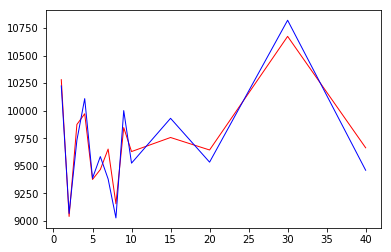

In [15]:
layer_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40]
niter =2000
tl = []
vl = []
for layer_size in layer_sizes:
    print('layer size ' + str(layer_size))
    layers_sizes = [116, layer_size, 2]
    weights = init_params(layers_sizes)
    train_losses, val_losses = gradient_descent(weights, lossAC, 
                                                train_inputs, train_targets, 
                                                lr=(10**(-2)), niter=niter, verbose=False,
                                                val_in=val_inputs, val_tar=val_targets)
    tl += [train_losses[-1]]
    vl += [val_losses[-1]]
    
# show losses
plt.plot(layer_sizes, tl, 'r', lw=1)
plt.plot(layer_sizes, vl, 'b', lw=1)
plt.show()

La première chose que l'on remarque est l'irrégularité des résultats. On pouvait pourtant s'attendre à ce que la perte d'entrainement diminue régulièrement avec la taille de de la couche intermédiaire mais ce n'est pas le cas.
On peut peut-etre l'expliquer par la difficulté (attendue) à prédire correctement la latitude et la longitude.
<br>
Dans un second temps on remarque que la perte de validation est sesiblement proche de la perte d'entrainement jusqu'à environ 10 puis elle s'en écarte. Le réseau commence à overfitter les données et donc il perd en perforamnce sur la base de validation. 

#### Evolution de la perte

Pour mettre en évidence le phénomène d'overfit que l'on pense avoir repéré, on considère deux paramétrisations, la première dans laquelle la couche intermédiaire compte 10 unités et la deuxième dans laquelle elle en compte 40.

Optimizing network parameters...
Iteration 0, training loss : 9939.273657445792, validation loss 9860.689085787928
Iteration 500, training loss : 9317.460241632123, validation loss 9739.88731760491
Iteration 1000, training loss : 9163.428702024485, validation loss 9716.383761708354
Iteration 1500, training loss : 9026.293114730342, validation loss 9656.09905362764
Iteration 2000, training loss : 8806.101230186845, validation loss 9526.518791074028
Iteration 2500, training loss : 7791.924500040358, validation loss 8337.938863323649
Iteration 3000, training loss : 7434.076892916422, validation loss 8206.181598731804
Iteration 3500, training loss : 7261.988204200579, validation loss 8176.406422568175
Iteration 4000, training loss : 7144.624903991787, validation loss 8203.808469653419
Iteration 4500, training loss : 7031.2429429006415, validation loss 8204.354867247303
Optimizing network parameters...
Iteration 0, training loss : 10538.480753034779, validation loss 10366.747875657153
Itera

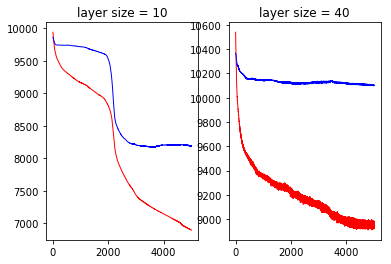

In [16]:
i = 1
for layer_size in [10, 40]:
    layers_sizes = [116, layer_size, 2]
    niter =5000
    weights = init_params(layers_sizes)
    train_losses, val_losses = gradient_descent(weights, lossAC, 
                                                train_inputs, train_targets, 
                                                lr=(10**(-8)), niter=niter, 
                                                val_in=val_inputs, val_tar=val_targets)
    # show losses
    plt.subplot(1, 2, i)
    i += 1
    plt.plot(np.arange(niter), train_losses, 'r', lw=1)
    plt.plot(np.arange(niter), val_losses, 'b', lw=1)
    plt.title('layer size = ' +str(layer_size))
plt.show()

Dans le cas avec 10 unités dans la couche intermédiaire, la perte de validation suit régulièrement celle d'entrainement (l'écart à la fin n'est pas très inquiétant car on ne s'attend pas à ce que la performance soit aussi bonne sur la valdiation que sur l'entrainement), au contraire le graphe de droite met bien en évidence l'overfit : la perte de validation ne diminue quasiement pas alorq que celle d'entrainement subit une forte chute. Le modèle n'arrive pas à généraliser.

# Prédiction de heatmap

On ne cherche plus à prédire exactement la latitude et la longitude de l'origine mais plutôt une distribution de la probabilité de l'origine. Celle-ci est représentée sous forme de heatmap.

#### Préparation des données

In [17]:
val_size = 0.4
targets = heatmaps
inputs = np.array(data.iloc[:,0:116])
train_inputs, val_inputs,train_targets, val_targets = train_test_split(inputs, targets, 
                                              test_size=val_size, random_state=3)

#### Fonction de perte

On cherche à caractériser la distance entre deux distributions de probabilités, on utilise donc la divergence de Kullback-Leibler définie par :
$$
D(p||q) = \sum p[i] * \log \frac{p[i]}{q[i]}
$$
On ajoute une quantité infinitésimale à chaque élément de la distribution pour éviter d'avoir à gérer des divisions par zéro.

In [18]:
def KL_distance(A,B):
    # Add a very small value to each element to avoid division by zero
    A = A + 10 ** (-8)
    B = B + 10 ** (-8)
    return np.sum((A) * np.log(A/B))

In [19]:
def lossKL(weights, inputs, targets):
    predictions = forward(inputs, weights, softmax)
    return KL_distance(targets, predictions)

#### Choix de la taille de la couche intermédaire

layer size 1
layer size 2
layer size 3
layer size 4
layer size 5
layer size 6
layer size 7
layer size 8
layer size 9
layer size 10
layer size 15
layer size 20
layer size 30
layer size 40


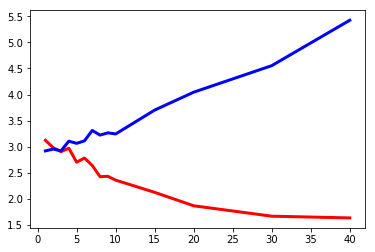

In [20]:
layer_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40]
niter =2000
tl = []
vl = []
for layer_size in layer_sizes:
    print('layer size ' + str(layer_size))
    layers_sizes = [116, layer_size, 400]
    weights = init_params(layers_sizes)
    train_losses, val_losses = gradient_descent(weights, lossKL, 
                                                train_inputs, train_targets, 
                                                lr=(10**(-2)), niter=niter, verbose=False,
                                                val_in=val_inputs, val_tar=val_targets)
    tl += [train_losses[-1]]
    vl += [val_losses[-1]]
    
# show losses
plt.plot(layer_sizes, tl, 'r', lw=3)
plt.plot(layer_sizes, vl, 'b', lw=3)
plt.show()

Contrairement à la première conifugration on botient des courbes aux quelles on pouvait s'attendre : plus la couche est grande mieux le réseau performe sur la base de test mais plus il a de difficulté sut la base de validation.
<br>
On choisit de définir la longuer de la couche intermédiaire à 10.

#### Evolution de la perte

Optimizing network parameters...
Iteration 0, training loss : 6.681762085541962, validation loss 6.389512656079795
Iteration 500, training loss : 2.5622571043372138, validation loss 3.0646587392008353
Iteration 1000, training loss : 2.4301628917112934, validation loss 3.1752760813188994
Iteration 1500, training loss : 2.3648662579064004, validation loss 3.3405898697076197
Iteration 2000, training loss : 2.3111092311728725, validation loss 3.435557464792154
Iteration 2500, training loss : 2.302116903355823, validation loss 3.510613097547409
Iteration 3000, training loss : 2.2817301787394952, validation loss 3.576094468088038
Iteration 3500, training loss : 2.2745393031085235, validation loss 3.604111238699123
Iteration 4000, training loss : 2.265489540354009, validation loss 3.6262683869421584
Iteration 4500, training loss : 2.266423868501343, validation loss 3.65302473709829


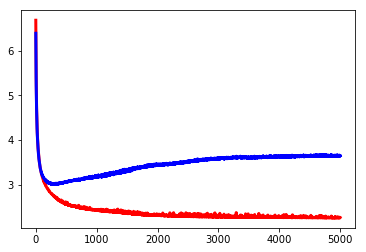

In [21]:
layer_size = 10
layers_sizes = [116, layer_size, 400]
niter =5000
weights = init_params(layers_sizes)
train_losses, val_losses = gradient_descent(weights, lossKL, 
                                            train_inputs, train_targets, 
                                            lr=(10**(-2)), niter=niter, 
                                            val_in=val_inputs, val_tar=val_targets)
# show losses
plt.plot(np.arange(niter), train_losses, 'r', lw=3)
plt.plot(np.arange(niter), val_losses, 'b', lw=3)
plt.show()

Les pertes suivent une trajectoire attendue. Une forte diminution au début qui correspond aux plus grandes variations dans les poids (plus ils sont éloignés de la bonne valeur plus ils se déplacent) qui se poursuit de plus ne plus modérément. L'erreur de validation suit la meme forte diminution mais sui tune assymptote plus élevée. Comme dans le cas de la longitude et de la latitude cet écart enre perte d'entrainement et de validation n'est pas important car on ne s'attend pas à ce que le réseau performe aussi bien sur la base de validation que sur celle d'entrainement : c'est une courbe assez classique lorsqu'on supervise l'apprentissage d'un réseau de neurones.